<h1><center>Introduction to Cython</center></h1>
<br>
<h3><center>MKI Code Coffee</center></h3>
<h3><center>April 1, 2016</center></h3>
<h3><center>Keaton Burns</center></h3>

## Some vocabulary

* Python
  * A language specification

* CPython
  * A Python interpretor written in C
  * The standard/reference implementation of Python

* Cython
  * A language that is a *superset* of Python
  * A compiler that converts Cython code to C code for use in CPython

## What can you do with Cython?

* Wrap C and C++ libraries for use in Python
* Tune numerical Python code to (near) C performance

## How do you use Cython?

* Less easy: write Cython files (.pyx files) and compile to C
* Super easy: use Jupyter notebooks!

## Let's see how to speed up a function

First, what is Cython really good at improving?
* Numerics with high Python overheads
* Numpy code with a lot of indexing

It *usually* doesn't help much with well-vectorized Numpy code

Let's write a 2D discrete convolution function for our test case.  

In [1]:
# Imports and notebook setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
%load_ext Cython

In [2]:
# Write a plain-python reference implementation
def python_convolve_2d(image, kernel, output):
    # Clear output
    output[:] = 0.
    # Index image by i=[0, I), j=[0, J)
    I = image.shape[0]
    J = image.shape[1]
    # Index kernel by m=[-M, M], n=[-N, N]
    M = kernel.shape[0] // 2
    N = kernel.shape[1] // 2
    # Perform convolution
    # Skip output pixels where kernel extends beyond image
    for i in range(M, I-M):
        for j in range(N, J-N):
            value = 0.
            for m in range(-M, M+1):
                for n in range(-N, N+1):
                    value += kernel[M+m, N+n] * image[i+m, j+n]
            output[i, j] = value

This is a good potential target for performance improvements via Cython, since it includes things like nested loops and a lot of Numpy array indexing.

To test our function, let's build some smoothed random image, and the kernel to compute its Laplacian.

In [3]:
# Just defining a couple functions to help setup some test inputs
def fourier_filter(image, kmax, lmax):
    coeffs = np.fft.fft2(image)
    coeffs[kmax+1:-kmax, :] = 0
    coeffs[:, lmax+1:-lmax] = 0
    return np.fft.ifft2(coeffs)

def build_random_image(size, modes):
    image = 0.5 - np.random.rand(size, size)
    image = fourier_filter(image, modes, modes).real.copy()
    scale = np.max(np.abs(image))
    return (image / scale)

image = build_random_image(size=512, modes=5)
output = np.zeros_like(image)

# Second-order finite difference stencil for the Laplacian
kernel = np.array([[  0,  1,  0],
                   [  1, -4,  1], 
                   [  0,  1,  0]], dtype=np.float64)

And let's just take a look at our test input and it's Laplacian, computed using our convolution function.

<IPython.core.display.Javascript object>


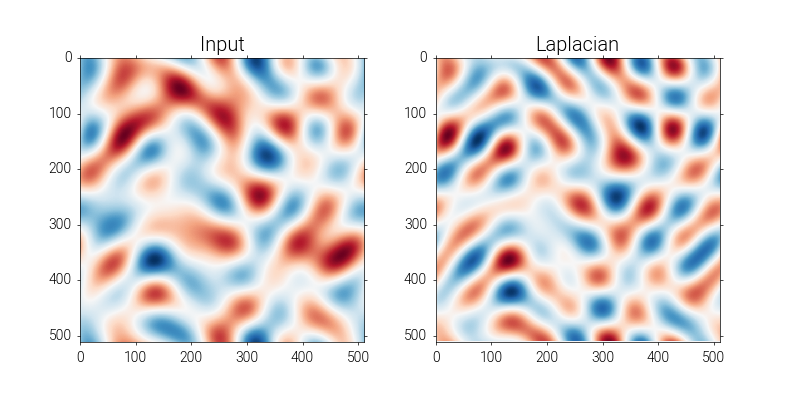

In [4]:
python_convolve_2d(image, kernel, output)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax1.imshow(image)
ax1.set_title('Input')
ax2.imshow(output)
ax2.set_title('Laplacian')

Finally let's time the function.

In [5]:
%timeit python_convolve_2d(image, kernel, output)

1 loops, best of 3: 2.12 s per loop


Next, we'll see what sort of improvements we can get by using Cython.

## Put it in Cython

First, we'll just copy the function into a cell with `%%cython` at the top, and see what baseline improvements the Cython compiler can make over the regular CPython interpreter.

To make the modifications clear below, I'll remove all comments from the original function, and add comments to point out the changes I'm making in each Cython version.

In [6]:
%%cython
### CHANGE: define function in a Cython block

def cython_convolve_2d(image, kernel, output):
    
    output[:] = 0.
    I = image.shape[0]
    J = image.shape[1]
    M = kernel.shape[0] // 2
    N = kernel.shape[1] // 2
    
    for i in range(M, I-M):
        for j in range(N, J-N):
            value = 0.
            for m in range(-M, M+1):
                for n in range(-N, N+1):
                    value += kernel[M+m, N+n] * image[i+m, j+n]
            output[i, j] = value

In [7]:
%timeit cython_convolve_2d(image, kernel, output)

1 loops, best of 3: 1.59 s per loop


We can also use `%%cython -a` to examine the compiled version of the code.  The shading of the text indicates the length of the compiled C code for each line, and is a useful indicator of where you can improve things by adding type information in Cython, etc.  Click a line to view the underlying C code.

## Add types to function signature

The first real modification we can try is to add type information to the function inputs.  This is accomplished with a syntax that's pretty similar to regular type declarations in C.  For array arguments, we add colons inside brackets for each dimension of the array, and a `::1` slice to indicate the fastest memory axis, e.g. the last axis for a standard C-ordered Numpy array.

In [8]:
%%cython

### CHANGE: Type our inputs as 2D, C-ordered arrays of doubles (np.float64)
def cython_convolve_2d(double[:,::1] image, 
                       double[:,::1] kernel, 
                       double[:,::1] output):
    
    output[:] = 0.
    I = image.shape[0]
    J = image.shape[1]
    M = kernel.shape[0] // 2
    N = kernel.shape[1] // 2
    
    for i in range(M, I-M):
        for j in range(N, J-N):
            value = 0.
            for m in range(-M, M+1):
                for n in range(-N, N+1):
                    value += kernel[M+m, N+n] * image[i+m, j+n]
            output[i, j] = value

In [9]:
%timeit cython_convolve_2d(image, kernel, output)

1 loops, best of 3: 726 ms per loop


## Add types to internal variables

Next, we'll declare the types of the interval variables we're using inside the function, using the `cdef` command.

In [10]:
%%cython

def cython_convolve_2d(double[:,::1] image, 
                       double[:,::1] kernel, 
                       double[:,::1] output):
    
    output[:] = 0.
    ### CHANGE: Declare the types of all internal variables
    cdef int I = image.shape[0]
    cdef int J = image.shape[1]
    cdef int M = kernel.shape[0] // 2
    cdef int N = kernel.shape[1] // 2
    ### CHANGE: Preallocate the variables that come up in the loop, again with types
    cdef int i, j, m, n
    cdef double value

    for i in range(M, I-M):
        for j in range(N, J-N):
            value = 0.
            for m in range(-M, M+1):
                for n in range(-N, N+1):
                    value += kernel[M+m, N+n] * image[i+m, j+n]
            output[i, j] = value

In [11]:
%timeit cython_convolve_2d(image, kernel, output)

100 loops, best of 3: 9.32 ms per loop


Clearly having everything typed makes a huge difference in performance!

## Avoid indexing checks

Finally, we can avoid the overhead associated with Python's indexing checks.  First, we can use a decorator to turn off `wraparound` checks for our function, which means that it won't try to interpret negative indeces as indexing backwards from the end of an array.  Second, we can turn off the `boundscheck` option, which means that our function won't raise an error if we index past the end of an array.  

Since we know for sure that our function only performs positive and in-range indexing, we can safely turn off these protections and gain performance by having Cython skip the associated checks.

In [12]:
%%cython

cimport cython

### CHANGE: Add decorators disabling wraparound and boundschecking for the function
@cython.wraparound(False)
@cython.boundscheck(False)
def cython_convolve_2d(double[:,::1] image, 
                       double[:,::1] kernel, 
                       double[:,::1] output):

    output[:] = 0.
    cdef int I = image.shape[0]
    cdef int J = image.shape[1]
    cdef int M = kernel.shape[0] // 2
    cdef int N = kernel.shape[1] // 2
    cdef int i, j, m, n
    cdef double value

    for i in range(M, I-M):
        for j in range(N, J-N):
            value = 0.
            for m in range(-M, M+1):
                for n in range(-N, N+1):
                    value += kernel[M+m, N+n] * image[i+m, j+n]
            output[i, j] = value

In [13]:
%timeit cython_convolve_2d(image, kernel, output)

100 loops, best of 3: 4.88 ms per loop


## Overall improvement

Let's calculate the speedup we've gained over the initial plain Python implementation with just these changes:

In [14]:
plain_python = %timeit -o python_convolve_2d(image, kernel, output)

1 loops, best of 3: 2.09 s per loop


In [15]:
cythonized = %timeit -o cython_convolve_2d(image, kernel, output)

100 loops, best of 3: 4.66 ms per loop


In [16]:
print('Speedup: %.2fx' %(plain_python.best / cythonized.best))

Speedup: 448.02x


<br>
## Thanks!